# Andrew Id: dnkundin
# Mobile Big Data Analysis

## Date: Feb 5th, 2025
# Inferring locations and mobility from mobile phone metadata

## Exploratory data analysis

In [34]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Read the data and calculate summary statistics

In [35]:
# load the dataset cdr
dataset_cdr = pd.read_csv("./cdr.csv")
dataset_cdr

,caller_id,recipient_id,date,time,duration,tower_id,prefecture,hour
0,6RUMEMGE,23RJAXQ1,2020-01-01,00:24:29,99,tower23,BLITTA,0
1,RH9604A1,VF8PQW02,2020-01-01,00:25:24,152,tower84,TCHAOUDJO,0
2,UHX8BQMK,SB2GZAJU,2020-01-01,00:59:41,100,tower62,LOME COMMUNE,0
3,E35NJHCH,C18O8PW7,2020-01-01,01:26:30,89,tower32,EST-MONO,1
4,536AAL2Y,LFXCTNCS,2020-01-01,01:36:15,113,tower37,GOLFE,1
...,...,...,...,...,...,...,...,...
13508,RR13MTWZ,XP0CZNVG,2020-03-31,22:58:07,62,tower67,MOYEN-MONO,22
13509,N6OH31ZA,Y2SSO9KF,2020-03-31,23:02:30,116,tower39,GOLFE,23
13510,XAJI0Y6D,XP0CZNVG,2020-03-31,23:19:40,109,tower54,LOME COMMUNE,23
13511,YWUR3EKV,7N3IRJTC,2020-03-31,23:24:17,123,tower22,BINAH,23


In [36]:
# dataset 2, towers
dataset_towers = pd.read_csv("./towers.csv")
dataset_towers

,tower_id,longitude,latitude
0,tower26,0.497253,9.860677
1,tower60,1.296134,6.162604
2,tower2,1.180004,6.272656
3,tower51,1.614710,6.353378
4,tower71,1.305223,7.585271
...,...,...,...
98,tower99,0.436116,10.922298
99,tower67,1.551156,7.284856
100,tower64,1.196773,6.182105
101,tower47,1.179417,9.640990


## Summary statistics

In [37]:
dataset_cdr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13513 entries, 0 to 13512
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   caller_id     13513 non-null  object
 1   recipient_id  13513 non-null  object
 2   date          13513 non-null  object
 3   time          13513 non-null  object
 4   duration      13513 non-null  int64 
 5   tower_id      13513 non-null  object
 6   prefecture    13513 non-null  object
 7   hour          13513 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 844.7+ KB


In [38]:
dataset_towers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tower_id   103 non-null    object 
 1   longitude  103 non-null    float64
 2   latitude   103 non-null    float64
dtypes: float64(2), object(1)
memory usage: 2.5+ KB


In [39]:
# calculate the number of transactions
num_transaction_cdr = len(dataset_cdr)
print('Total transactions:',num_transaction_cdr)

Total transactions: 13513


In [40]:
# unique callers
unique_callers_cdr = dataset_cdr['caller_id'].unique()
print('Unique Callers:',len(unique_callers_cdr))

Unique Callers: 145


In [41]:
#unique receivers
unique_receivers_cdr = dataset_cdr['recipient_id'].unique()
print('Unique Receivers:',len(unique_receivers_cdr))

Unique Receivers: 146


In [42]:
# unique days
unique_days_cdr = dataset_cdr['date'].unique()
print('Unique Days:',len(unique_days_cdr))

Unique Days: 91


In [43]:
# Calculate average calls per day per subscriber (as caller)
calls_per_caller = dataset_cdr.groupby('caller_id')['date'].count()
average_calls_per_caller = calls_per_caller.mean()
print(f"Average calls placed per day per subscriber: {(average_calls_per_caller / len(unique_days_cdr)):.2f}")

# Calculate average calls per day per subscriber (as receiver)
calls_per_receiver = dataset_cdr.groupby('recipient_id')['date'].count()
average_calls_per_receiver = calls_per_receiver.mean()
print(f"Average calls received per day per subscriber: {(average_calls_per_receiver/ len(unique_days_cdr)):.2f}")


Average calls placed per day per subscriber: 1.02
Average calls received per day per subscriber: 1.02


## Part 2: Map the tower

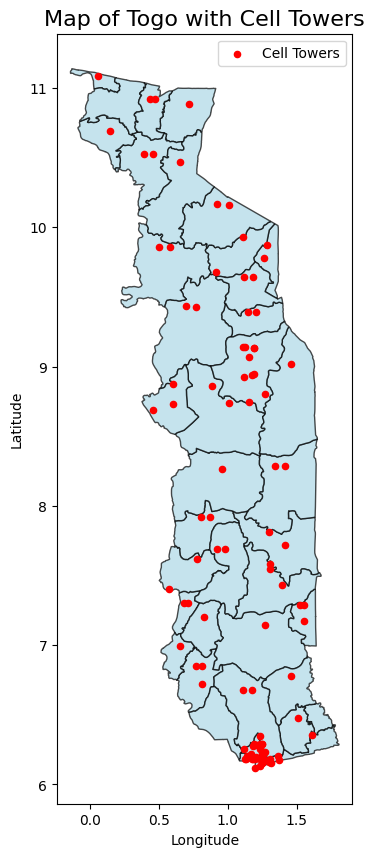

In [45]:
import geopandas as gpd
import folium
import warnings
warnings.filterwarnings("ignore")


togo_prefectures = gpd.read_file("./prefectures.geojson")


# Convert tower data to a GeoDataFrame
tower_gdf = gpd.GeoDataFrame(
    dataset_towers, geometry=gpd.points_from_xy(dataset_towers.longitude, dataset_towers.latitude), crs="EPSG:4326"
)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
togo_prefectures.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.7, label="Prefectures")
tower_gdf.plot(ax=ax, color="red", markersize=20, label="Cell Towers")

# Customize the map
ax.set_title("Map of Togo with Cell Towers", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# Save or display the map
plt.savefig("togo_towers_map.png", dpi=300, bbox_inches="tight")
plt.show()

## Part 3: Infering home prefectures

### 3.2 Appoach selected: Modal Tower Algorithm
Steps:
- Aggregate Call Counts Per Caller and Prefecture
- Assign Home Prefecture

In [46]:
# Counting calls per caller_id and prefecture
prefecture_caller_counts = dataset_cdr.groupby(['caller_id', 'prefecture']).size().reset_index(name='call_count')

# most frequently used prefecture per caller
prefecture_home = prefecture_caller_counts.loc[prefecture_caller_counts.groupby('caller_id')['call_count'].idxmax()]

results_df = prefecture_home[['caller_id', 'prefecture']]
results_df.columns = ['caller_id', 'home_prefecture']

# save dataset into csv
results_df.to_csv("home_prefecture_modal_tower.csv", index=False)

# print inferred home prefectures
print(results_df)

     caller_id home_prefecture
11    06BA9LHR         OTI-SUD
18    0706DUPJ    LOME COMMUNE
25    0HHVC11B       TCHAOUDJO
28    1DJTB0AG           GOLFE
43    1S9T7ERF           KOZAH
...        ...             ...
1138  YDW44SWN       TANDJOARE
1144  YWUR3EKV           KOZAH
1153  Z4G9GYD1           KOZAH
1159  Z6A73C32        EST-MONO
1172  ZGDN1K5V           KLOTO

[145 rows x 2 columns]


## 3.6 Second approach: Nighttime Calls Algorithm


In [47]:
# Filter for nighttime calls (20:00 - 06:00)
nighttime_calls_df = dataset_cdr[(dataset_cdr['hour'] >= 20) | (dataset_cdr['hour'] < 6)]

# Count nighttime calls per caller and prefecture
caller_night_prefecture_counts_df = nighttime_calls_df.groupby(['caller_id', 'prefecture']).size().reset_index(name='night_call_count')

# Select the most frequent nighttime prefecture per caller
home_prefecture_night_df = caller_night_prefecture_counts_df.loc[
    caller_night_prefecture_counts_df.groupby('caller_id')['night_call_count'].idxmax()
]

# Rename columns for clarity
home_prefecture_night_df = home_prefecture_night_df[['caller_id', 'prefecture']]
home_prefecture_night_df.columns = ['caller_id', 'home_prefecture']

# Saving thr table to a CSV file
home_prefecture_night_df.to_csv("home_location_nighttime.csv", index=False)

# Display the first few rows
print(home_prefecture_night_df.head())


   caller_id home_prefecture
8   06BA9LHR             OTI
11  0706DUPJ      AGOE-NYIVE
20  0HHVC11B       TCHAOUDJO
21  1DJTB0AG      AGOE-NYIVE
36  1S9T7ERF           KOZAH


## 3.6 Compare the results of the modal tower  and nighttime calls algorithms

Steps:
- Merge the results from both methods
- Count how many subscribers have the same inferred home prefecture in both approaches.
- Count how many subscribers have different inferred home prefectures

In [48]:
# Merge the two results on caller_id
comparison_df = results_df.merge(home_prefecture_night_df, on="caller_id", suffixes=('_modal', '_unique_days'))

# Count agreement and disagreement
agreement_count_df = (comparison_df['home_prefecture_modal'] == comparison_df['home_prefecture_unique_days']).sum()
disagreement_count_df = (comparison_df['home_prefecture_modal'] != comparison_df['home_prefecture_unique_days']).sum()

# Print results
print(f"Subscribers with the same inferred home prefecture: {agreement_count_df}")
print(f"Subscribers with different inferred home prefectures: {disagreement_count_df}")

Subscribers with the same inferred home prefecture: 111
Subscribers with different inferred home prefectures: 27


## Part 4: Inferring mobility

##  Steps to Identify Weekly Home Locations and Visualize Movement
1. Use the Unique Days Method
2. Group by Week & Identify Most Frequent Prefecture
3. Select Five Subscribers from Different Prefectures.
4. Generate a Table & Map of movement trajectories


<Figure size 1200x800 with 0 Axes>

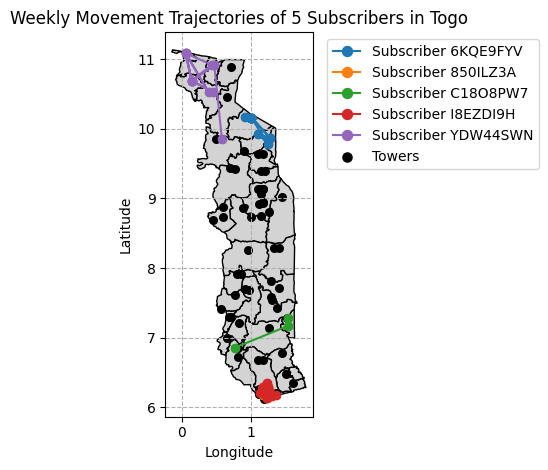

In [49]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# date manipulation
dataset_cdr['date'] = pd.to_datetime(dataset_cdr['date'])
dataset_cdr['week'] = dataset_cdr['date'].dt.to_period('W').astype(str)

# Computing unique days
weekly_home_locations_df = dataset_cdr.groupby(['caller_id', 'week', 'prefecture', 'tower_id'])['date'].nunique().reset_index()
weekly_home_locations_df.rename(columns={'date': 'unique_days'}, inplace=True)

# Choose the prefecture with the highest unique day count per week
weekly_home_locations_df = weekly_home_locations_df.sort_values(by=['caller_id', 'week', 'unique_days'], ascending=[True, True, False])
weekly_home_locations_df = weekly_home_locations_df.drop_duplicates(subset=['caller_id', 'week'], keep='first')

# Step 3: Select 5 subscribers from different prefectures
selected_subscribers = weekly_home_locations_df.groupby('caller_id').first().reset_index().sample(n=5, random_state=42)
selected_caller_ids = selected_subscribers['caller_id'].tolist()

# Filter only selected subscribers
selected_movement_df = weekly_home_locations_df[weekly_home_locations_df['caller_id'].isin(selected_caller_ids)]

# generating table
selected_movement_df.to_csv("weekly_home_locations_df.csv", index=False)

# Step 4: Load Togo map for visualization
map_togo = gpd.read_file("./prefectures.geojson")

# Load tower locations
gdf_towers = gpd.GeoDataFrame(dataset_towers, geometry=gpd.points_from_xy(dataset_towers.longitude, dataset_towers.latitude))

# Merge prefecture coordinates with movement data
movement_with_coords = selected_movement_df.merge(gdf_towers, on="tower_id", how="left")

# Plot subscriber trajectories on map of Togo
plt.figure(figsize=(12, 8))
map_togo.plot(color="lightgrey", edgecolor="black")  # Plot base map
for caller_id, data in movement_with_coords.groupby("caller_id"):
    plt.plot(data['longitude'], data['latitude'], marker="o", linestyle="-", label=f"Subscriber {caller_id}")

plt.scatter(gdf_towers.longitude, gdf_towers.latitude, c="black",s=30, label="Towers")
plt.title("Weekly Movement Trajectories of 5 Subscribers in Togo")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, markerscale=1.2, frameon=True)
plt.grid(True, linestyle="--", alpha=1)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()